# Replication the paper ["An image is worth 16 x 16 Words"](https://www.google.com/search?q=an+image+is+worth+16x16+words&rlz=1C5GCCM_en___IN1163&oq=an+image+i&gs_lcrp=EgZjaHJvbWUqBwgAEAAYgAQyBwgAEAAYgAQyBggBEEUYOTIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIGCAcQRRhA0gEIMjIwNmowajeoAgCwAgA&sourceid=chrome&ie=UTF-8#:~:text=An%20Image%20is%20Worth%2016x16%20Words%3A%20Transformers,https%3A//arxiv.org%20%E2%80%BA%20cs) ViT Paper


### Downloading and preparing the dataset from [Kaggle](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/msingh361/.cache/kagglehub/datasets/balabaskar/tom-and-jerry-image-classification/versions/3


In [12]:
import os
import PIL
from pathlib import Path
import matplotlib.pyplot as plt
dataset_path = 'dataset_path/tom_and_jerry/tom_and_jerry/'
for directory,sub_directory,files in os.walk(Path(dataset_path)):
    print(f"The Directory '{directory}' has {len(sub_directory)} sub-directories and {len(files)} files in it.")
print(os.listdir(dataset_path))

The Directory 'dataset_path/tom_and_jerry/tom_and_jerry' has 4 sub-directories and 0 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/tom' has 0 sub-directories and 1930 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/neither_tom_nor_jerry' has 0 sub-directories and 1528 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/jerry' has 0 sub-directories and 1240 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/both_tom_and_jerry' has 0 sub-directories and 780 files in it.
['tom', 'neither_tom_nor_jerry', 'jerry', 'both_tom_and_jerry']


In [33]:
import random
import shutil
train_path = 'dataset_path/tom_and_jerry/train'
test_path = 'dataset_path/tom_and_jerry/test'
subset_directory = 'dataset_path/tom_and_jerry/subset'
# division_percentage = 0.9
for folder in os.listdir(dataset_path):
    print(f"[INFO] working on folder : {folder}")
    total_len = len(os.listdir(dataset_path+'/'+folder))
    train_len = int(0.9 * total_len)
    test_len = int(0.1 * total_len)
    print(f"Total Len : {total_len} \nTrain Len : {train_len} \nTest Len : {test_len}")
    x = random.sample(os.listdir(dataset_path+'/'+folder),train_len)
    print(x)
    print(len(x),len(set(x)))
    os.makedirs(f"{train_path}/{folder}",exist_ok=True)
    os.makedirs(f"{test_path}/{folder}",exist_ok=True)
    os.makedirs(f"{subset_directory}/train/{folder}",exist_ok=True)
    os.makedirs(f"{subset_directory}/test/{folder}",exist_ok=True)
    # moving to train
    print("[INFO] Moving data to Train Folder")
    for images in x:
        shutil.move(f"{dataset_path}/{folder}/{images}",f"{train_path}/{folder}")

    # moving the remaining to test
    print("[INFO] Moving data to Test path")
    for images in os.listdir(dataset_path+'/'+folder):
        shutil.move(f"{dataset_path}/{folder}/{images}",f"{test_path}/{folder}")
    
    #copying to small subset folder for purpose of testing the model at initial phase
    print("creating small sample size for test training")
    
    subset_sample_size = 100
    x = random.sample(os.listdir(f"{train_path}/{folder}"),subset_sample_size)
    for ix in range(len(x)):
        if ix < 90:
            # to train_subset
            shutil.copy(src=f"{train_path}/{folder}/{x[ix]}",dst=f"{subset_directory}/train/{folder}")
        else:
            shutil.copy(src=f"{train_path}/{folder}/{x[ix]}",dst=f"{subset_directory}/test/{folder}")
            # to test_subset

    print("="*30)
    
    

[INFO] working on folder : tom
Total Len : 1930 
Train Len : 1737 
Test Len : 193
['frame322.jpg', 'frame2669.jpg', 'frame5388.jpg', 'frame2112.jpg', 'frame5304.jpg', 'frame3981.jpg', 'frame3815.jpg', 'frame5290.jpg', 'frame4424.jpg', 'frame2947.jpg', 'frame2613.jpg', 'frame4743.jpg', 'frame3737.jpg', 'frame5288.jpg', 'frame4607.jpg', 'frame1273.jpg', 'frame155.jpg', 'frame4528.jpg', 'frame2496.jpg', 'frame5010.jpg', 'frame4909.jpg', 'frame4315.jpg', 'frame1130.jpg', 'frame5069.jpg', 'frame2634.jpg', 'frame5180.jpg', 'frame1774.jpg', 'frame1401.jpg', 'frame4912.jpg', 'frame4759.jpg', 'frame4088.jpg', 'frame4200.jpg', 'frame5454.jpg', 'frame720.jpg', 'frame2604.jpg', 'frame4201.jpg', 'frame2221.jpg', 'frame3404.jpg', 'frame4171.jpg', 'frame2865.jpg', 'frame3244.jpg', 'frame577.jpg', 'frame1974.jpg', 'frame2971.jpg', 'frame4092.jpg', 'frame5213.jpg', 'frame4951.jpg', 'frame4096.jpg', 'frame1943.jpg', 'frame5293.jpg', 'frame2886.jpg', 'frame400.jpg', 'frame1179.jpg', 'frame4274.jpg', 'fra

### Above code is only one time running.

Work will progress for further from below

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import glob
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import v2

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("✅ Setting Device as CUDA...")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    print("🫡 Device is set is MPS...")
    device = torch.device('mps')
else:
    print("No accelerator available 🥺 ...using CPU for this task...")

🫡 Device is set is MPS...


#### Sample dataset preperation

dataset_path/tom_and_jerry/subset/train
tried new:  tom
tom
jerry
jerry
jerry
jerry
tom
both_tom_and_jerry
neither_tom_nor_jerry
neither_tom_nor_jerry


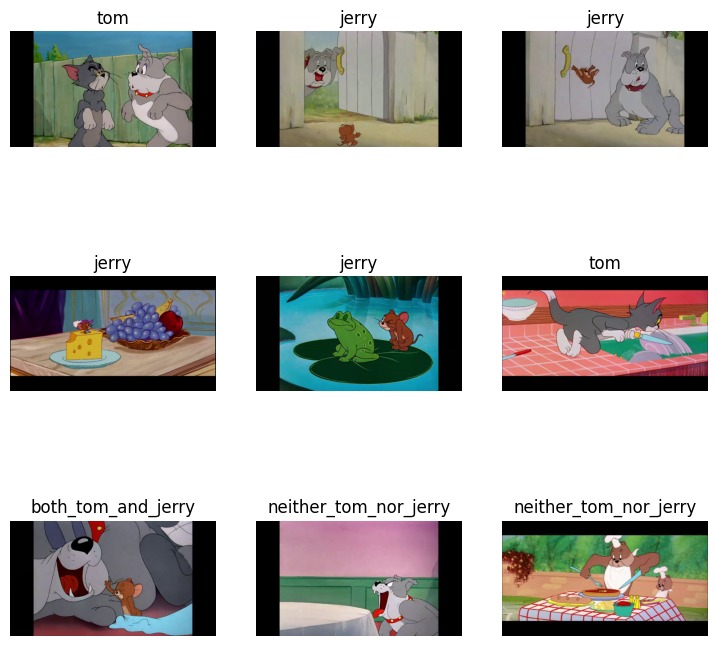

In [3]:
import random
import shutil
from pathlib import Path
train_path = 'dataset_path/tom_and_jerry/train'
test_path = 'dataset_path/tom_and_jerry/test'
subset_directory = 'dataset_path/tom_and_jerry/subset'
train_subset = subset_directory + '/train'
test_subset = subset_directory + '/test'
print(train_subset)
images_path = glob.glob(train_subset+'/*/*.jpg')
print('tried new: ',Path(images_path[0]).parent.name)
fig = plt.figure(figsize=(9,9))
col = 3
row = 3
images = random.sample(images_path,col*row)

for i in range(1,row*col+1):
    fig.add_subplot(row,col,i)
    plt.imshow(Image.open(images[i-1]))
    name = str(Path(images[i-1]).parent).split('/')[-1]
    print(name)
    plt.title(name)
    plt.axis(False)
    
    



In [87]:

import numpy as np
class TomAndJerryDataset(Dataset):
    def __init__(self,dataset_path,transform=None, target_transform=None):
        super().__init__()
        self.transformation = transform

        self.target_transform = target_transform
        self.classes = os.listdir(dataset_path)
        self.class_to_index = {self.classes[ix]:ix for ix in range(len(self.classes))}
        self.index_to_class = {ix:self.classes[ix] for ix in range(len(self.classes))}
        self.images = glob.glob(dataset_path+'/*/*.jpg')
        self.dataset_path = dataset_path
        self.to_tensor = v2.ToTensor()
        # print(self.images[0])


    def __len__(self,):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image).convert('RGB')
        
        # label = str(Path(self.images[index]).parent).split('/')[-1]
        label = Path(self.images[index]).parent.name
        # print(label)
        # print(np.array(image).shape)
        # plt.imshow(image)

        if self.transformation is not None:
            image = self.transformation(image)
        else:
            image = self.to_tensor(image)

        
        label = self.class_to_index[label]
        if self.target_transform:
            label = self.target_transform(label)
        # plt.imshow(image)
        
        return image,label
    

transform = v2.Compose([
    v2.Resize((224,224)),
    v2.RandomVerticalFlip(p=0.34),
    v2.ToTensor()

])

/Users/msingh361/Uber/Projects/python310_venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
import os
os.cpu_count()

10

In [105]:
train_dataset = TomAndJerryDataset(train_subset,transform)
test_dataset = TomAndJerryDataset(test_subset,transform=transform)

train_data_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)
train_dataset.class_to_index,train_dataset.index_to_class

/Users/msingh361/Uber/Projects/python310_venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


({'tom': 0, 'neither_tom_nor_jerry': 1, 'jerry': 2, 'both_tom_and_jerry': 3},
 {0: 'tom', 1: 'neither_tom_nor_jerry', 2: 'jerry', 3: 'both_tom_and_jerry'})

In [68]:
len(train_dataset)

360

In [7]:
len(train_dataset),len(test_dataset)

(360, 40)

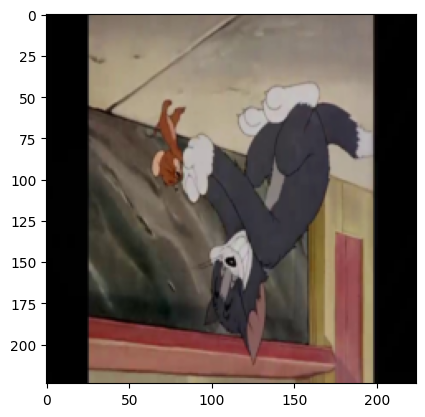

In [8]:
image_train,label = train_dataset[359]
plt.imshow(image_train.permute(1,2,0)),label,image_train.shape
plt.show()


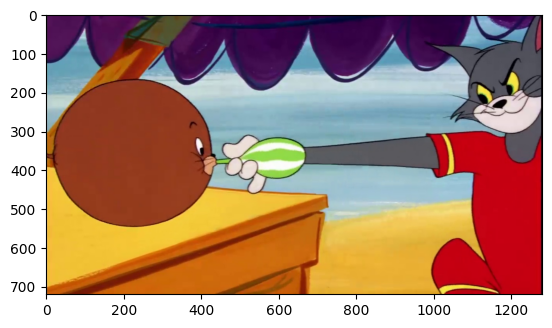

In [9]:
image,label = test_dataset[39]
plt.imshow(image.permute(1,2,0)),label,image.shape
plt.show()

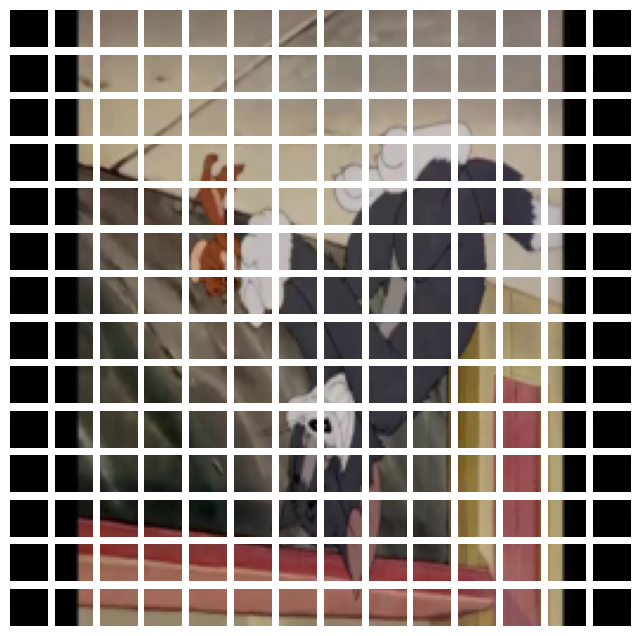

In [10]:
# Getting patches of image for visualization
image1 = image_train.permute(1, 2, 0)  # shape: (H, W, C)
PATCH_SIZE = 16

H, W, C = image1.shape
images_in_single_row = W // PATCH_SIZE
rows = H // PATCH_SIZE

fig = plt.figure(figsize=(8, 8))

for row in range(rows):
    for col in range(images_in_single_row):
        patch = image1[row*PATCH_SIZE:(row+1)*PATCH_SIZE,
                       col*PATCH_SIZE:(col+1)*PATCH_SIZE, :]

        ax = fig.add_subplot(rows, images_in_single_row, row*images_in_single_row + col + 1)
        ax.imshow(patch)
        ax.axis("off")

plt.show()


### Let's beigin coding ViT componenets by componenets
In this I might be using pytorch's inbuilt attention layer and will also try to implement one from scratch, just for practise and fun

In [11]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ Vision Transformer (ViT) forward pipeline                                │
# └──────────────────────────────────────────────────────────────────────────┘
# 1) Split image into fixed-size patches
#        image ──► [Patches]
# 2) Linearly embed each patch (patch embedding / projection)
#        [Patches] ──► [Patch Embeddings]
# 3) Flatten patch embeddings into a token sequence
#        [Patch Embeddings] ──► [Tokens: (num_patches × d_model)]
# 4) Add learnable positional embeddings to preserve order
#        [Tokens] + [Positional Embeddings] ──► [Positional Tokens]
# 5) Feed the sequence through Transformer encoder layers
#        [Positional Tokens] ──► [Encoded Tokens]
# 6) Classification head (e.g., take [CLS] token or pooled output → MLP)
#        [Encoded Tokens] ──► [MLP Classifier] ──► [Logits]
# 7) Compute loss / prediction
#        [Logits] ──► [CrossEntropy / Predicted Class]




In [185]:
## Equation 1: Splitting the image into patches and creating embeddings

# Input shape  : (3, 224, 224) → (channels, height, width) for a single RGB image
# Patch size   : (16, 16)
#
# Number of patches:
#     (Height * Width) / (Patch_Height * Patch_Width)
#     = (224 * 224) / (16 * 16)
#     = 196 patches
#
# Each patch shape:
#     Patch_Height * Patch_Width * Channels
#     = 16 * 16 * 3
#     = 768
#
# Therefore:
#     Output dimension after patch embedding
#     = (Number of patches) × (Flattened patch dimension)
#     = 196 × 768
#
# Embedding layer:
#     Input  : 16 × 16 × 3  (flattened per patch = 768)
#     Output : Projected to a vector of dimension D (e.g., 768)


class PatchCreation(nn.Module):
    def __init__(self,
                 input_color_channel: int,
                 patch_size: int,
                 embedding_dimensions : int = None):
        super().__init__()
        self.patch_size = patch_size
        self.output_channels = patch_size*patch_size*input_color_channel
        self.patching_conv = nn.Conv2d(input_color_channel,
                                    #    self.output_channels,
                                    embedding_dimensions,
                                       kernel_size=patch_size,
                                       stride=patch_size,
                                       padding=0)
        
        # self.patch_embedding_layer = nn.Linear(self.output_channels,embedding_dimensions)
        self.flatten = nn.Flatten(start_dim=2)

    
    def forward(self,x):
        # print(x.shape)
        image_dimension = x.shape[2]
        assert image_dimension%self.patch_size == 0, f"Given image dimension {image_dimension} is not divisble into perfect number of patches of size {self.patch_size}"
        if len(x.shape)==3:
            x = x.unsqueeze(0)
        return self.patching_conv(x).flatten(2).permute(0,2,1)
        

patch_creation = PatchCreation(3,16,768)
# print(patch_creation.shape)
random_image=torch.randn(32,3,224,224)
rand_img_output = patch_creation(random_image)
patch_creation(image_train).shape,patch_creation(random_image).shape




(torch.Size([1, 196, 768]), torch.Size([32, 196, 768]))

In [186]:
rand_img_output.shape,rand_img_output.dtype,rand_img_output.shape[0]

(torch.Size([32, 196, 768]), torch.float32, 32)

In [187]:
"""
This one is Failed and not working code
"""
class ClsAndPositionalEmbeddings(nn.Module):
    def __init__(self,
                #  patch_dimension : int,
                 embedding_dimension: int,
                 total_positions: int,
                 dtype: torch.dtype,
                 batch_size:int):
        super().__init__()
        self.cls_token = torch.tensor(torch.rand(batch_size,1,embedding_dimension),dtype=dtype,requires_grad=True)
        
        # to create postional embedding, 
        # taking input as patch embedding
        # appending/concatinating the self.cls token in it's beginneing
        # add positional embedding to it and return
        # then getting it checked it with the gemini
        self.total_tokens = total_positions + 1

        # self.positional_embeddings = 
        self.positional_embeddings = nn.Parameter(torch.rand(batch_size,self.total_tokens,embedding_dimension),
                                                  requires_grad=True)
        # print(self.positional_embeddings.shape)

    def forward(self,x):
        # print(x.shape,self.cls_token.shape)
        return torch.concat([self.cls_token,x],dim=1)+self.positional_embeddings
    
ready_tensor = ClsAndPositionalEmbeddings(rand_img_output.shape[-1],
                           rand_img_output.shape[1],
                           rand_img_output.dtype,
                           rand_img_output.shape[0])(rand_img_output)
ready_tensor.shape,ready_tensor[0][0][0]

/var/folders/lz/r1vc8j397gz84904s7n_yp4w0000gn/T/ipykernel_9035/2123551281.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.cls_token = torch.tensor(torch.rand(batch_size,1,embedding_dimension),dtype=dtype,requires_grad=True)


(torch.Size([32, 197, 768]), tensor(1.3669, grad_fn=<SelectBackward0>))

In [189]:
class ViTInputLayer(nn.Module):
    def __init__(self,in_channels:int,
                 patch_size: int,
                 image_size: int,
                 embedding_dimensions: int):
        super().__init__()
        self.patch_embeddings = PatchCreation(in_channels,
                                              patch_size,
                                              embedding_dimensions)
        # embed_dim = patch_size * patch_size * in_channels
        # batch independent
        self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dimensions),requires_grad=True)

        num_patches = (image_size//patch_size) ** 2
        num_positions = num_patches + 1

        self.positional_embeddings = nn.Parameter(torch.randn(1,num_positions,embedding_dimensions),requires_grad=True)

    def forward(self,x):
        batch_size = x.shape[0]
        patch_embeddings = self.patch_embeddings(x)
        cls_token = self.cls_token.expand(batch_size,-1,-1)
        return torch.concat((cls_token,patch_embeddings),dim=1) + self.positional_embeddings
        # print(cls_token[0][0][0],cls_token[1][0][0])
        # print(patch_embeddings.shape,cls_token.shape)


# ViTInputLayer(3,16,224,76)(random_image).shape

d = 768 
scale_dff = 2

vit_input = ViTInputLayer(3,16,224,d)
dummy_input = torch.randn(32,3,224,224)

output = vit_input(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 197, 768])


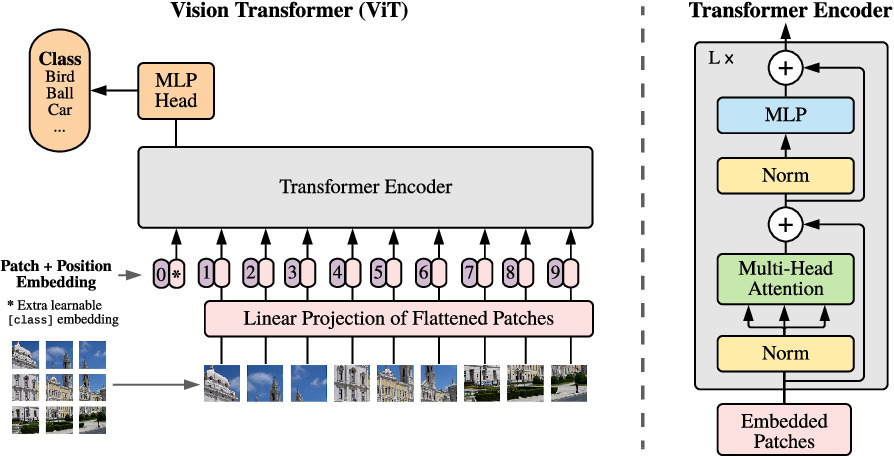

In [190]:
# class LayerNormalisation(nn.Module):
#     def __init__(self,embedding_dimension: int = 768):
#         super().__init__()
#         self.layer_norm = nn.LayerNorm(embedding_dimension)
    
#     def forward(self,x):
#         return self.layer_norm(x)
    
class LayerNormalisation(nn.Module):
    """
    Custom normalisastion fucntion we are defining.
    
    """
    def __init__(self,
                 embed_dim: int,
                 eps: float = 10**-6,):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(embed_dim))
        self.bias = nn.Parameter(torch.zeros(embed_dim))
        # self.beta = nn.para

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        std = x.std(dim=-1,keepdim=True)
        return self.alpha * (x-mean)/(std + self.eps) + self.bias

In [191]:
import math
class MultiHeadAttention(nn.Module):
    def __init__(self,embedding_dimension: int,
                 head: int,
                 ):
        super().__init__()
        assert embedding_dimension%head == 0, f"Embedding dimensions {embedding_dimension} is not divisible into {head} heads"
        self.w_q = nn.Linear(embedding_dimension,embedding_dimension)
        self.w_k = nn.Linear(embedding_dimension,embedding_dimension)
        self.w_v = nn.Linear(embedding_dimension,embedding_dimension)
        self.head = head
        self.d_k = embedding_dimension // head # dimension of each head
        self.w_o = nn.Linear(embedding_dimension, embedding_dimension)

    @staticmethod
    def attention(q,k,v, dropout:nn.Dropout = None):
        d_k = q.shape[-1]
        # print(v.shape)
        
        attention_scores = (torch.matmul(q,k.transpose(-2,-1))) / math.sqrt(d_k)
        # print(attention_scores.shape)
        attention_scores = attention_scores.softmax(dim=-1)
        # print(attention_scores.shape)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # try:
        #     torch.matmul(attention_scores,v)
        # except:
        #     print("error in here")

        return torch.matmul(attention_scores,v), attention_scores


    def forward(self,q,k,v):
        # print("first : ",q.shape)
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)
        

        # want to divide the embeddign dimensions into the number of heads in orfer to caclualte the self
        # attetnion

        #current dimension will be
        #.   (batch_size,no.of patches, embedding dimension)
        # then dimension will be (embedding dimension broken into equi diemnsion head)
        #     (batch_size, no.of patches , head, d_k)
        # then to work on each head we want to fead input as
        #.    (batch_size, head, no. of patches, d_k)

        query = query.view(query.shape[0],query.shape[1],self.head, self.d_k).transpose(1,2)
        key = key.view(key.shape[0],key.shape[1],self.head,self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.head, self.d_k).transpose(1,2)
        

        # contextualised representation of given input image emebeedings
        x, self.attention_score = MultiHeadAttention.attention(query,key,value)
        # print("goot the attentin score")
        # print("attention output shape : ", x.shape)

        # returning back to the original shape
        # current shape = (batchsize, heads, no.of patches, d_k)
        # then in next step -> (batch size, no. of patches, head, d_k)
        # finally -> (batche size, no. of patches, embnedding_dimension)
        # print('in here: ',x.transpose(1,2).contiguous().shape)
        # print(self.head*self.d_k)
        try:
            # x = x.transpose(1,2).contiguous().view(x.shape[0],x.shape[1],self.head*self.d_k)
            x = x.transpose(1,2).contiguous()
            x = x.view(x.shape[0], x.shape[1], self.head * self.d_k)
        except:
            print("real error is in here")
        # print("reshapeing shape: ",x.shape)

        

        return self.w_o(x)


# testing MHSA
# dummy testing
d = 768 
scale_dff = 2

mha_test = MultiHeadAttention(d,8)
dummy_input = torch.randn(32, 197, d)

output = mha_test(dummy_input,dummy_input,dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([32, 197, 768])
Output shape: torch.Size([32, 197, 768])


In [216]:
class FeedForwardLayer(nn.Module):
    def __init__(self,d_model:int
                 ,d_ff_scale:int = 2,
                 dropout_rate:float = 0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model,d_ff_scale*d_model),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(d_ff_scale*d_model,d_model),
            nn.Dropout(dropout_rate)
        )

    def forward(self,x):
        return self.mlp(x)

# dummy testing
d = 768 
scale_dff = 2

mlp_test = FeedForwardLayer(d,scale_dff)
dummy_input = torch.randn(32, 197, d)

output = mlp_test(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([32, 197, 768])
Output shape: torch.Size([32, 197, 768])


In [217]:
class EncoderBlock(nn.Module):
    def __init__(self,embedding_dimensions,
                 heads,
                 dff_scale:int = 2):
        super().__init__()

        # this is seperate from the the patch creation section
        # so input will be patch created
        # input dimension (bnatch size, no.of patches, embedding dimensions)
        
        # it wil have input passing through normalisation and then the MHSA
        # for residual connection copy of input getting attached to it
        self.normalisation_stage1 = LayerNormalisation(embedding_dimensions)
        self.mhsa = MultiHeadAttention(embedding_dimensions,heads)

        # output of above two layers is expected to be same as input 
        # (batchsize, no. of patches, embedding dimensions)

        self.normalisation_stage2 = LayerNormalisation(embedding_dimensions)
        self.feed_forward_layer = FeedForwardLayer(embedding_dimensions,d_ff_scale=dff_scale,dropout_rate=0.1)

    def forward(self, x):
        residual1 = x
        x = self.normalisation_stage1(x)
        x = self.mhsa(x,x,x) + residual1
        # print(x)
        residual2 = x
        return self.feed_forward_layer(self.normalisation_stage2(x)) + residual2
    
# dummy testing
d = 768 
scale_dff = 2
heads = 8

mlp_test = EncoderBlock(d,heads)
dummy_input = torch.randn(32, 197, d)

output = mlp_test(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([32, 197, 768])
Output shape: torch.Size([32, 197, 768])


In [218]:
# total encoder blocks building

class Encoder(nn.Module):
    def __init__(self,num_of_encoders: int,
                        embeddings: int,
                        dff_scale: int,
                        heads: int,
                        ):
        super().__init__()
        self.encoder_stack = nn.ModuleList(EncoderBlock(embedding_dimensions=embeddings,
                                                        heads=heads,
                                                        dff_scale=dff_scale) for _ in range(num_of_encoders))
        # print(self.encoder_stack)
        # for item in self.encoder_stack:
        #     print(item)
    
    def forward(self,x):
        for module in self.encoder_stack:
            x = module(x)
        return x

encoder_stack = Encoder(4,768,4,4)

dummy_input = torch.randn(32, 197, 768)

output = encoder_stack(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([32, 197, 768])
Output shape: torch.Size([32, 197, 768])


In [219]:
# ViTInputLayer(3,16,224)
print(device)

mps


In [247]:
"""
So far we have built the patch creation layer and encoder stack.
Now in terms of model, only one last thing is remaining,
That is Final classfication layer which will have total number of classes to 
clasify in it's output. so this i will code as sequential layer to final VIT class

"""

class VisionTransformer(nn.Module):
    def __init__(self,
                 in_channels: int,
                 image_size: int,
                 patch_size: int,
                 number_of_encoder: int,
                 embeddings: int,
                 d_ff_scale: int,
                 heads: int,
                 number_of_classes: int
                 ):
        super().__init__()
        self.input_layer = ViTInputLayer(in_channels,patch_size,image_size,embeddings).to(device)
        self.encoder_stack = Encoder(number_of_encoder,embeddings,d_ff_scale,heads).to(device)
        self.classification_head = nn.Sequential(
            nn.LayerNorm([embeddings]),
            nn.Linear(embeddings,number_of_classes)

        )

    def forward(self,x):
        # x = x[:,0,:]
        # print(x.shape)
        return self.classification_head(self.encoder_stack(self.input_layer(x))[:,0,:])
        


#dummy testing
vit_sample_model = VisionTransformer(3,224,16,4,256,4,8,4).to(device)
dummy_input_image = torch.randn((32,3,224,224)).to(device)
output = vit_sample_model(dummy_input_image)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(output[0],output[0].argmax())

Input shape: torch.Size([32, 197, 768])
Output shape: torch.Size([32, 4])
tensor([-0.4166,  0.3484,  0.2251,  0.7079], device='mps:0',
       grad_fn=<SelectBackward0>) tensor(3, device='mps:0')


In [248]:
from torchinfo import summary

summary(vit_sample_model,input_data=dummy_input_image)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 4]                   --
├─ViTInputLayer: 1-1                          [32, 197, 256]            50,688
│    └─PatchCreation: 2-1                     [32, 196, 256]            --
│    │    └─Conv2d: 3-1                       [32, 256, 14, 14]         196,864
├─Encoder: 1-2                                [32, 197, 256]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─EncoderBlock: 3-2                 [32, 197, 256]            789,760
│    │    └─EncoderBlock: 3-3                 [32, 197, 256]            789,760
│    │    └─EncoderBlock: 3-4                 [32, 197, 256]            789,760
│    │    └─EncoderBlock: 3-5                 [32, 197, 256]            789,760
├─Sequential: 1-3                             [32, 4]                   --
│    └─LayerNorm: 2-3                         [32, 256]           

### Optmizer creation

and Learning Rate Scheduling

In [249]:
# in paper the author's have used custom learning rate scheduling of linear function of 
# linear increase in the learning rate and cosine decay in the learning rate

import torch.optim as optim

optimizer = optim.AdamW(
    vit_sample_model.parameters(),
    lr = 3e-4,
    betas=(0.9,0.999),
    weight_decay=0.1
)

# learning rate scheduling

from torch.optim.lr_scheduler import LambdaLR

EPOCHS = 100
total_training_steps = EPOCHS * len(train_data_loader)
num_warmup_steps = int(0.23 * total_training_steps) # using 10 % of total training steps for LR warmup scheduiling
print(total_training_steps,num_warmup_steps)
def lr_lambda(current_step: int):
    """Learning rate schedule:
       - Linear warmup for num_warmup_steps
       - Cosine decay afterwards
    """
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    
    progress = float(current_step - num_warmup_steps) / float(max(1, total_training_steps - num_warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

scheduler = LambdaLR(optimizer=optimizer, lr_lambda= lr_lambda)
print(scheduler)
print(optimizer)

1200 276
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0
    maximize: False
    weight_decay: 0.1
)


### Time for coding the training loop|

- so far we have defined the LR scheduling and weight decay 
- we are done with model defining and data loader,
- now we are only left with trainig and validation loop desining
- one thing I think we are missing is making all of our code so far a 
- device agnositic code, which i will come back to latter and make the changes accordingly.

- moreover i think i will also have to code a single file for hyper-paramters from where we can just import the hyper paramters

Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([2, 0, 1, 2, 2, 0, 0, 0, 0, 1, 3, 0, 3, 0, 2, 3, 2, 3, 0, 0, 2, 2, 0, 0,
        1, 2, 3, 2, 3, 0, 3, 3])


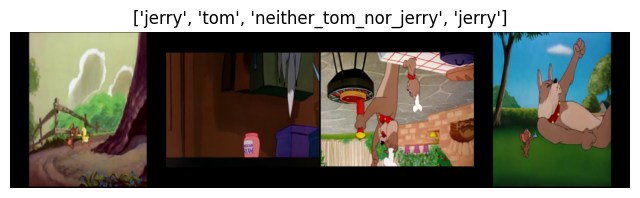

In [250]:
import torchvision
for images, labels in train_data_loader:
    print("Batch shape:", images.shape)
    print("Labels:", labels)

    img_grid = torchvision.utils.make_grid(images[:4], nrow=4)  # show 4 images
    plt.figure(figsize=(8,8))
    plt.imshow(img_grid.permute(1, 2, 0))  # C,H,W → H,W,C
    plt.title([train_dataset.index_to_class[int(l)] for l in labels[:4]])
    plt.axis("off")
    plt.show()

    break  


In [251]:
# # training loop
# losses = []             
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# for epoch in range(EPOCHS):

#     # train part
#     vit_sample_model.train()
#     loss_average = 0
    
#     n = len(train_data_loader)
    
#     for image,label in train_data_loader:
#         optimizer.zero_grad()
#         image = image.to(device)
#         label = label.to(device)
#         pred_logits = vit_sample_model(image)
#         loss = criterion(pred_logits,label)
#         loss_average+=loss.item()
#         # print(loss)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
        
#     losses.append(loss_average/n)
#     print(f"Epoch {epoch+1} | loss: {loss_average/n}")
    
    
    

In [252]:
import torch.nn as nn
def accuracy_fn(y_pred, y_true):
    """
    y_pred: (batch_size, num_classes) raw logits
    y_true: (batch_size,) ground truth class indices
    """
    preds = torch.argmax(y_pred, dim=1)
    correct = (preds == y_true).sum().item()
    # print(preds,y_true)
    acc = correct / y_true.size(0)
    return acc

# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = nn.CrossEntropyLoss()
train_losses = [] 
train_accuracies = []
learning_rates = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    vit_sample_model.train()
    loss_average = 0
    accuracy_average = 0
    n = len(train_data_loader)
    
    for image, label in train_data_loader:

        learning_rates.append(scheduler.get_last_lr()[0])
        image = image.to(device)
        label = label.to(device)
        

        pred_logits = vit_sample_model(image)
        
        loss = criterion(pred_logits, label)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        loss_average += loss.item()
        accuracy_average += accuracy_fn(pred_logits,label)
        # print()
        # Accuracy()
        # break
        
    epoch_avg_loss = loss_average / n
    epoch_avg_accuracy = accuracy_average / n
    train_losses.append(epoch_avg_loss)
    train_accuracies.append(epoch_avg_accuracy)

    vit_sample_model.eval()
    val_avg_loss = 0
    val_avg_acc = 0
    n_test = len(test_data_loader)

    with torch.inference_mode():
        for test_images, test_labels in test_data_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            pred_logits = vit_sample_model(test_images)
            loss = criterion(pred_logits, test_labels)

            val_avg_loss += loss.item()
            val_avg_acc += accuracy_fn(pred_logits, test_labels)

    val_epoch_avg_loss = val_avg_loss / n_test
    val_epoch_avg_accuracy = val_avg_acc / n_test
    val_losses.append(val_epoch_avg_loss)
    val_accuracies.append(val_epoch_avg_accuracy)
    

    
    print(
    f"Epoch {epoch+1} | "
    f"train_loss: {epoch_avg_loss:.4f} | train_accuracy: {epoch_avg_accuracy:.4f} | "
    f"val_loss: {val_epoch_avg_loss:.4f} | val_accuracy: {val_epoch_avg_accuracy:.4f} | "
    f"LR: {scheduler.get_last_lr()[0]:.6f}"
)
learning_rates.append(scheduler.get_last_lr()[0])

Epoch 1 | train_loss: 1.4159 | train_accuracy: 0.2786 | val_loss: 1.3555 | val_accuracy: 0.5312 | LR: 0.000013
Epoch 2 | train_loss: 1.3928 | train_accuracy: 0.2474 | val_loss: 1.4546 | val_accuracy: 0.1562 | LR: 0.000026
Epoch 3 | train_loss: 1.3968 | train_accuracy: 0.2344 | val_loss: 1.3903 | val_accuracy: 0.1562 | LR: 0.000039
Epoch 4 | train_loss: 1.3858 | train_accuracy: 0.2734 | val_loss: 1.4120 | val_accuracy: 0.1562 | LR: 0.000052
Epoch 5 | train_loss: 1.3893 | train_accuracy: 0.2630 | val_loss: 1.3868 | val_accuracy: 0.1875 | LR: 0.000065
Epoch 6 | train_loss: 1.4045 | train_accuracy: 0.2344 | val_loss: 1.3269 | val_accuracy: 0.5781 | LR: 0.000078
Epoch 7 | train_loss: 1.4590 | train_accuracy: 0.2318 | val_loss: 1.4582 | val_accuracy: 0.1562 | LR: 0.000091
Epoch 8 | train_loss: 1.4377 | train_accuracy: 0.2240 | val_loss: 1.4848 | val_accuracy: 0.1562 | LR: 0.000104
Epoch 9 | train_loss: 1.4089 | train_accuracy: 0.2448 | val_loss: 1.3953 | val_accuracy: 0.1875 | LR: 0.000117
E

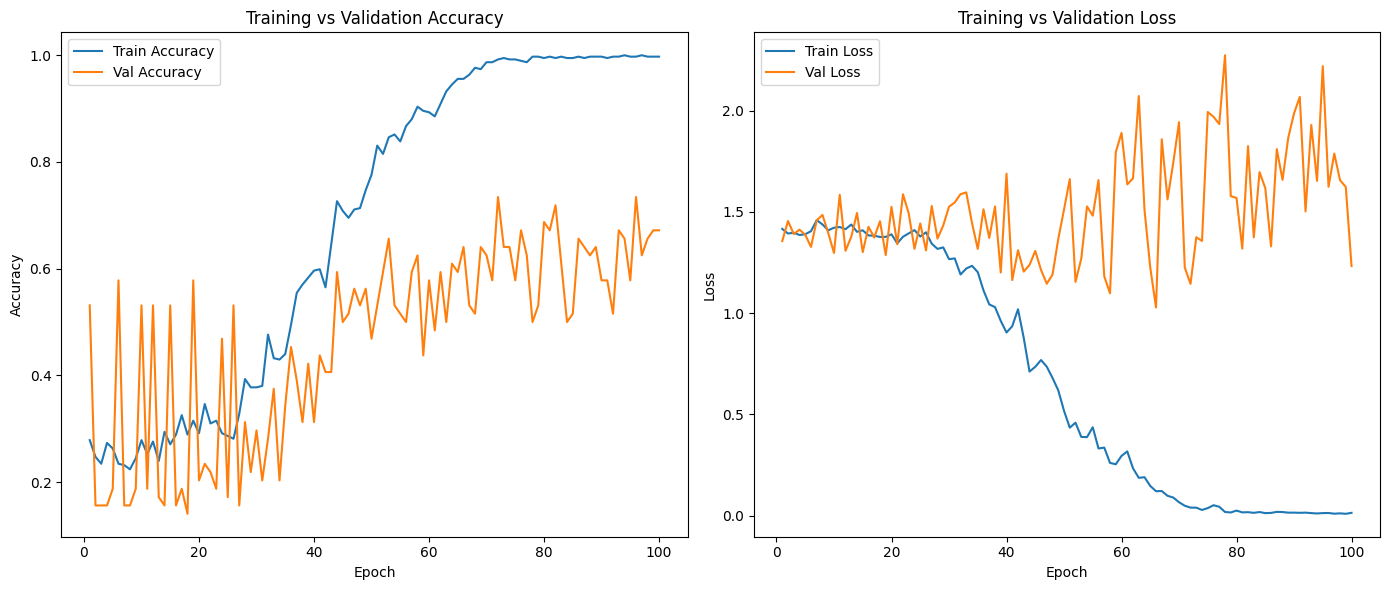

In [253]:
fig = plt.figure(figsize=(14, 6))

# Subplot 1: Accuracy
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(np.arange(1, EPOCHS+1), train_accuracies, label='Train Accuracy')
ax1.plot(np.arange(1, EPOCHS+1), val_accuracies, label='Val Accuracy')
ax1.set_title("Training vs Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Subplot 2: Loss
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(np.arange(1, EPOCHS+1), train_losses, label='Train Loss')
ax2.plot(np.arange(1, EPOCHS+1), val_losses, label='Val Loss')
ax2.set_title("Training vs Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()


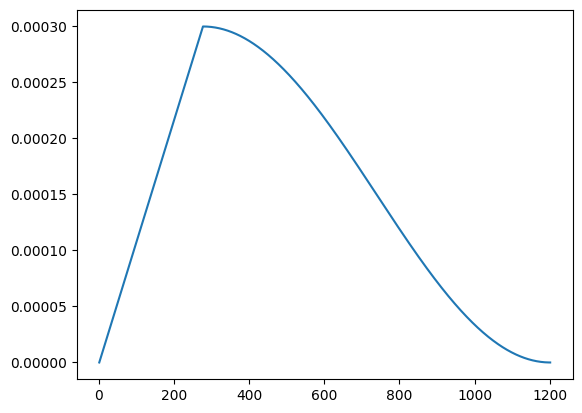

In [227]:
plt.plot(np.arange(1,EPOCHS*n+2,1),learning_rates)

In [237]:
# model testing
vit_sample_model.eval()
with torch.inference_mode():
    for image,label in test_data_loader:
        print(image.shape,label.shape)
        y_preds = vit_sample_model(image.to(device))
        break
    

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [241]:
train_dataset.index_to_class[0]

'tom'

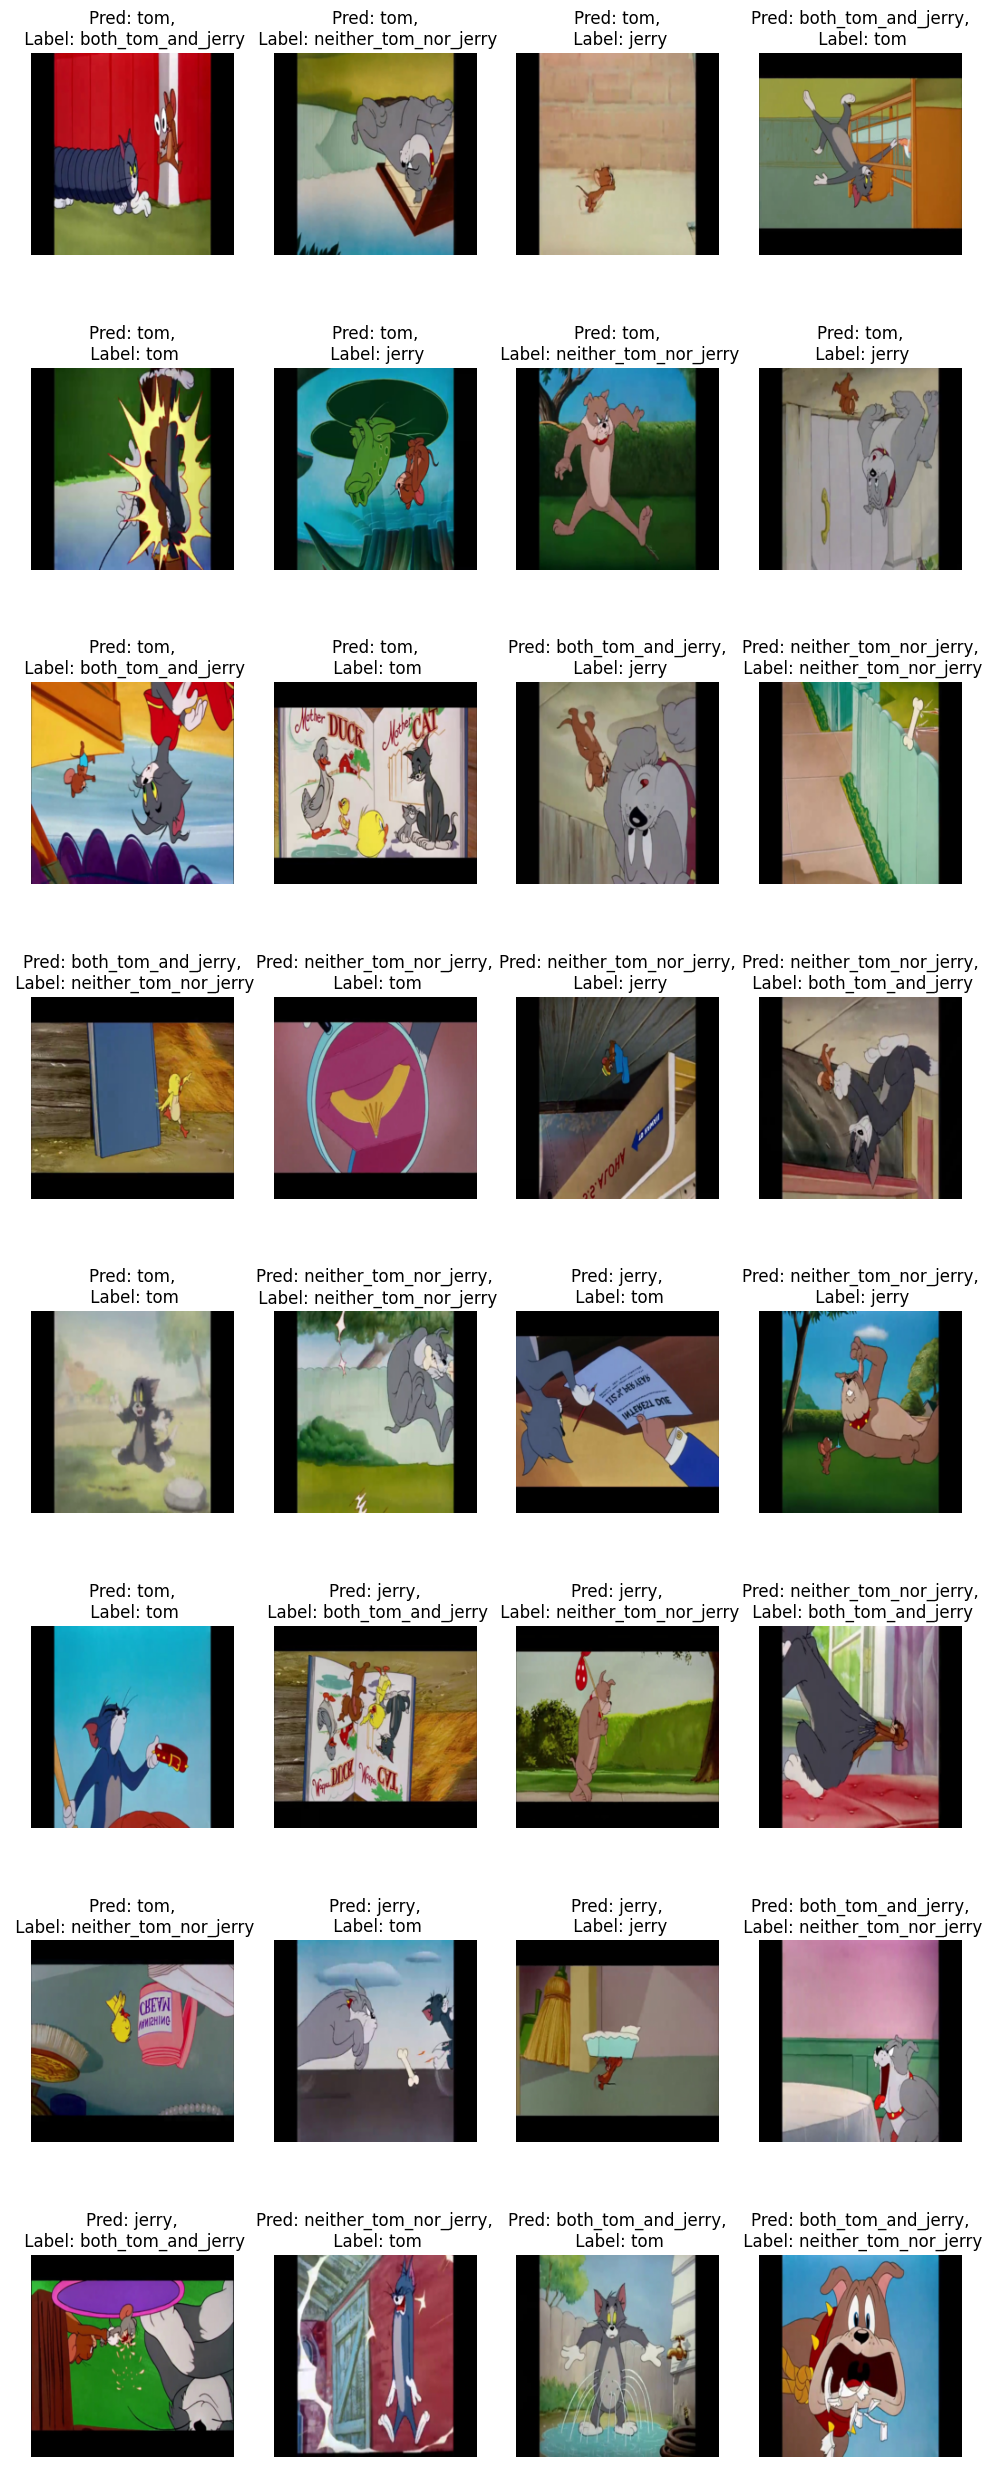

In [245]:
y_pred_eval = torch.argmax(y_preds,dim=1)
fig = plt.figure(figsize=(12,32))
rows = 8
cols = 4
for idx in range(rows * cols):
    ax = fig.add_subplot(rows, cols, idx + 1)
    img = images[idx].cpu().permute(1, 2, 0)  # from (C,H,W) → (H,W,C)
    ax.imshow(img)
    ax.set_title(f"Pred: {train_dataset.index_to_class[y_pred_eval[idx].item()]},\n Label: {train_dataset.index_to_class[labels[idx].item()]}")
    ax.axis("off")

plt.show()
